In [1]:
import pandas as pd

In [8]:
df = pd.read_csv("tud-barnard-energy.csv")
df["time"] = pd.to_datetime(df["timestamp"])
df["energy_diff"] = df["barnard.hpc.energy"].diff()
df["time_diff"] = df["time"].diff().dt.total_seconds()
df["power"] = df["energy_diff"] / df["time_diff"]
df["power [kW]"] = df["power"] / 1000
core_phase_start = pd.to_datetime("2023-05-12T03:03:45+02:00")
df["time_offset [s]"] = (df["time"] - core_phase_start).dt.total_seconds()
core_phase_end = pd.to_datetime("2023-05-12T12:33:55+02:00")
core_phase_end - core_phase_start

Timedelta('0 days 09:30:10')

# Due to inaccurate timestamps the energy/power conversion has some local outliers that skew the result

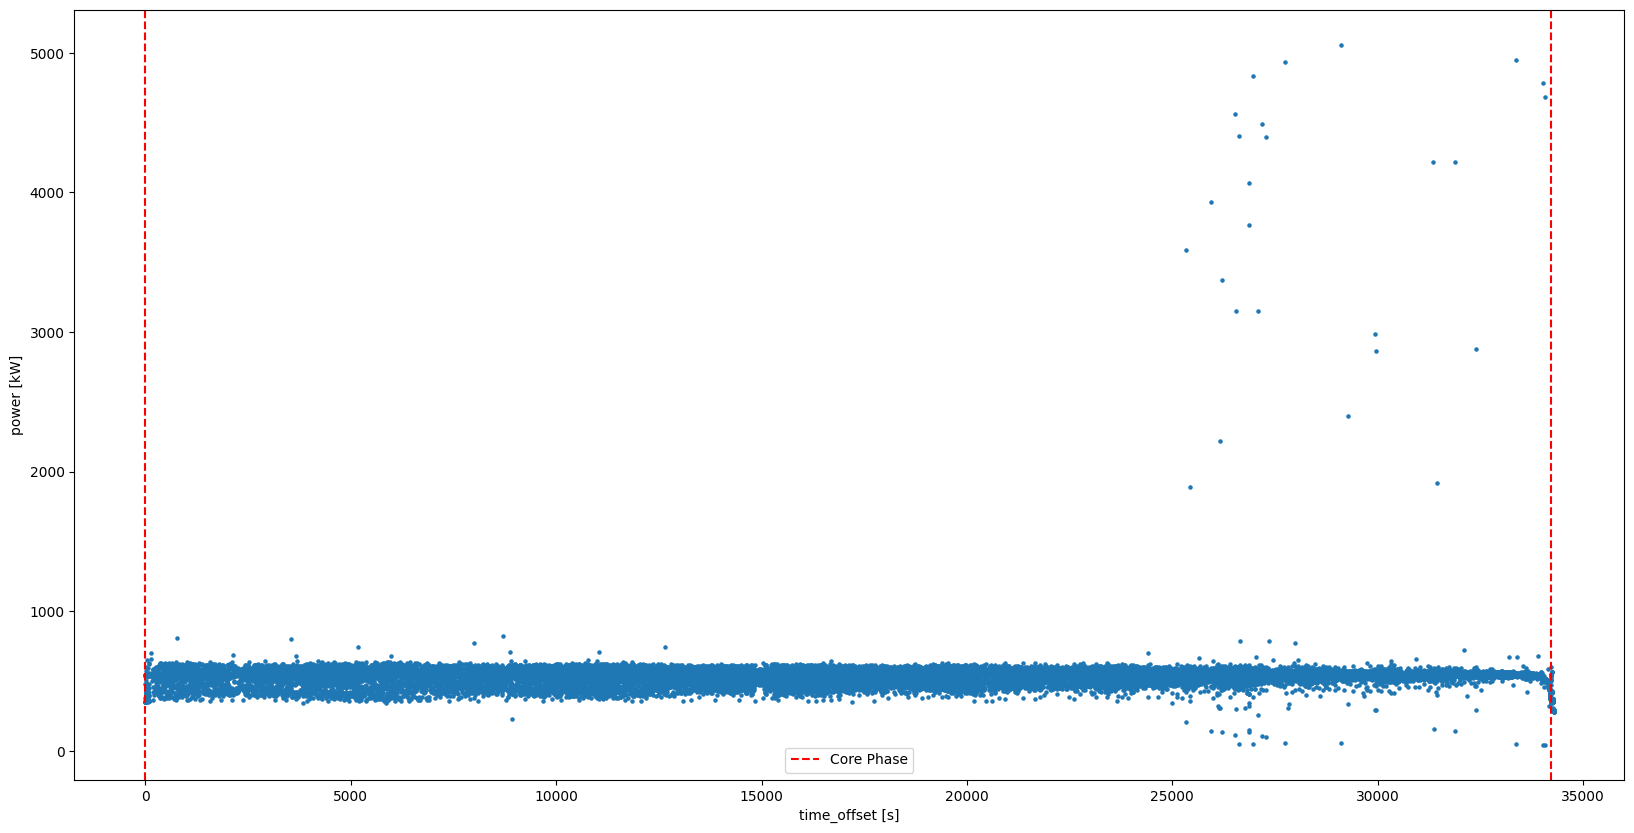

In [9]:
ax = df.plot(x="time_offset [s]", y="power [kW]", kind="scatter", figsize=(20, 10), marker=".")
ax.axvline(0, color='r', linestyle='--', label='Core Phase')
ax.axvline((core_phase_end - core_phase_start).total_seconds(), color='r', linestyle='--')
ax.legend()

Max error 2.41%, mean error 0.62%


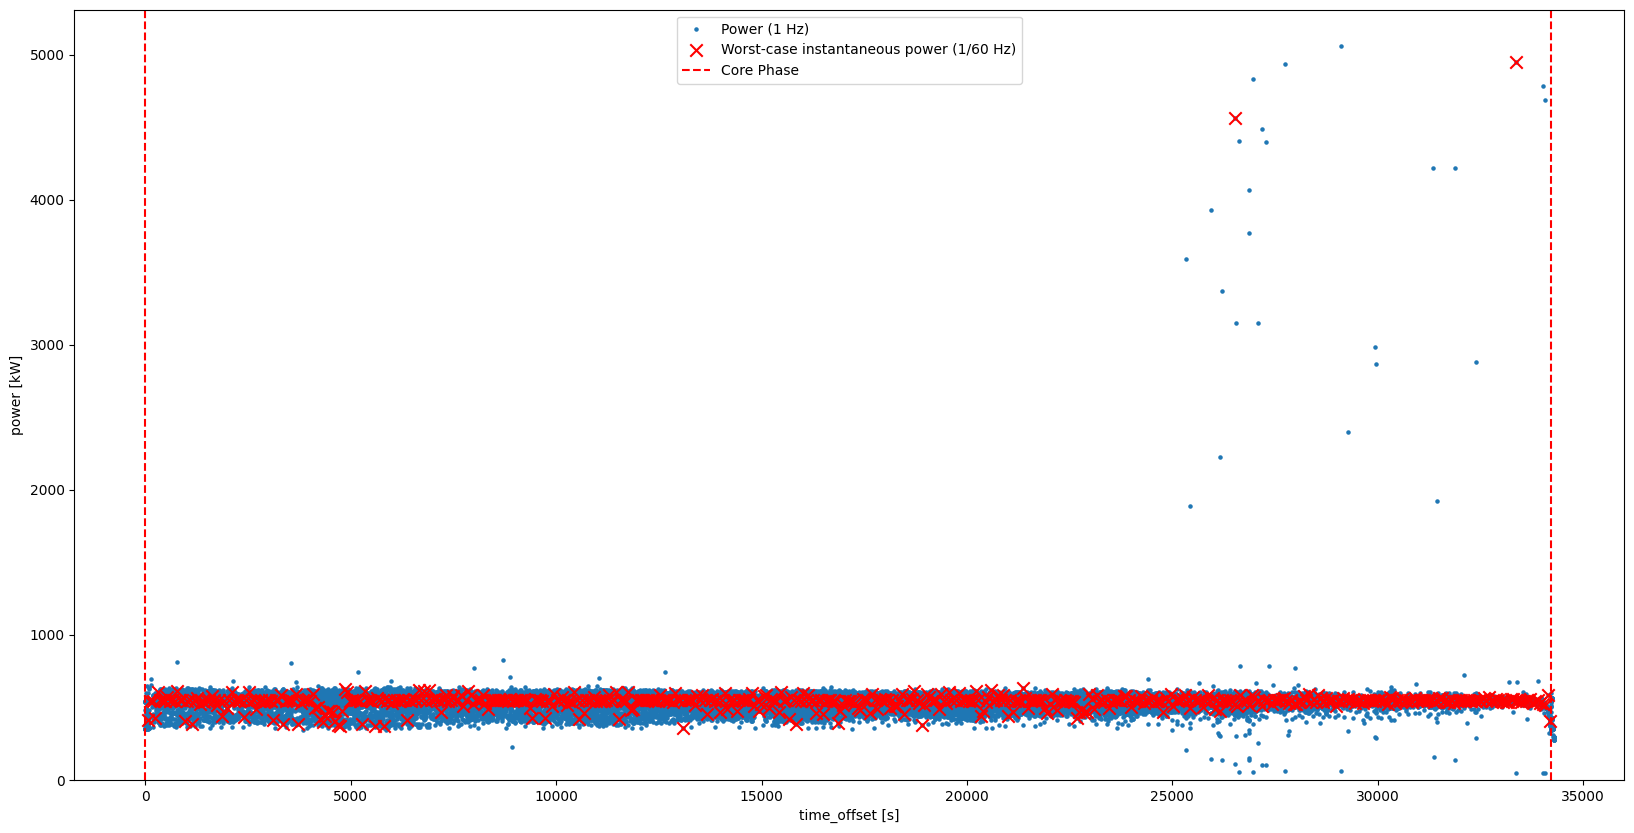

In [10]:
df_core = df[(df["time"] >= core_phase_start) & (df["time"] < core_phase_end)]
true_power = df_core.power.mean()
max_error = 0
errors = []
for shift in range(60):
        df_shifted = df_core[df_core["time"].dt.second == shift]
        shifted_power = df_shifted.power.mean()
        error = abs(true_power - shifted_power) / true_power
        errors.append(error)
        if error > max_error:
            max_error = error
            df_worst = df_shifted

print(f"Max error {max_error:.2%}, mean error {sum(errors) / len(errors):.2%}")

ax = df.plot(x="time_offset [s]", y="power [kW]", kind="scatter", figsize=(20, 10), marker=".", label="Power (1 Hz)")
ax.set_ylim(0)
df_worst.plot(x="time_offset [s]", y="power [kW]", kind="scatter", marker="x", s=80, ax=ax, color="red", label="Worst-case instantaneous power (1/60 Hz)")
ax.axvline(0, color='r', linestyle='--', label='Core Phase')
ax.axvline((core_phase_end - core_phase_start).total_seconds(), color='r', linestyle='--')
ax.legend()